## fine-tuning BERT with Trainer API
transformers에서는 손쉬운 학습을 위해 Trainer API를 제공합니다.
Trainer를 사용하여 더 쉽게 BERT를 fine-tuning할 수 있습니다.

In [1]:
import os
import warnings
import random

import seaborn as sns
import numpy as np
import pandas as pd
import datasets
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings(action='ignore')

In [2]:
RANDOM_SEED = 42

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 
    
seed_everything(RANDOM_SEED)

In [3]:
model_checkpoint = "bert-base-cased"
batch_size = 8
save_checkpoint_path = "./checkpoints/bert-base-cased"

huggingface 에서 tokenizer를 불러옵니다.

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

dataset을 가져옵니다.

In [5]:
dataset = pd.read_excel("ISEARdata.xls")
label_dict = {"anger" : 0, "sadness" : 1, "disgust" : 2,"shame" : 3, "fear" : 4, "joy" : 5,"guilt" : 6 }
labels = list(label_dict.keys())
dataset["label"] = dataset["emotion"].replace(labels, list(range(len(labels))))

train_test_split을 사용하여 train data와 validation data를 나눕니다.

In [6]:
dataset_train, dataset_val = train_test_split(dataset,test_size = 0.3,random_state = RANDOM_SEED)

In [7]:
dataset.head()

,emotion,sentence,label
0,joy,[ On days when I feel close to my partner and ...,5
1,fear,Every time I imagine that someone I love or I ...,4
2,anger,When I had been obviously unjustly treated and...,0
3,sadness,When I think about the short time that we live...,1
4,disgust,At a gathering I found myself involuntarily si...,2


학습에 사용될 Dataset을 정의합니다.

In [8]:
class TrainDataset(Dataset):
    def __init__(self, dataset, sent_key, label_key, bert_tokenizer):
        self.sentences = [ bert_tokenizer(i,truncation=True,return_token_type_ids=False) for i in dataset[sent_key] ]
        self.labels = [np.int64(i) for i in dataset[label_key]]


    def __getitem__(self, i):
        self.sentences[i]["label"] = self.labels[i]
        return self.sentences[i]


    def __len__(self):
        return len(self.sentences)
    
class TestDataset(Dataset):
    def __init__(self, dataset, sent_key, bert_tokenizer):
        self.sentences = [ bert_tokenizer(i,truncation=True,return_token_type_ids=False) for i in dataset[sent_key] ]
        
    def __getitem__(self, i):
        return self.sentences[i]
    
    def __len__(self):
        return len(self.sentences)

In [9]:
data_train = TrainDataset(dataset_train, "sentence", "label", tokenizer)
data_validation = TrainDataset(dataset_val, "sentence", "label", tokenizer)

모델의 성능을 측정하기 위한 metric(지표)를 불러옵니다.  
수행할 과제는 Text Classification이기 때문에 glue-qnli의 metric을 가져옵니다.  
qnli의 metric은 Accuracy입니다.  

In [10]:
metric = load_metric("glue", "qnli")

In [11]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

`Trainer`에 들어갈 `TrainingArguments`를 정의합니다.  
모델이 저장될 디렉토리, epoch, learning_rate등을 설정할 수 있습니다.  
CPU로 학습할 경우 시간이 너무 오래걸릴 수 있습니다. GPU환경이 아니라면 Colab 사용을 권장합니다.  
예제에서는 epoch을 1로 설정했습니다. 사용 환경에 맞춰 적절하게 epoch을 조절합시다. 

In [12]:
metric_name = "accuracy"

args = TrainingArguments(
    save_checkpoint_path,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

학습에 사용할 모델을 hugginface에서 불러옵니다.

In [13]:
num_labels = 7

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

`Trainer`를 생성해줍니다.

In [14]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=data_train,
    eval_dataset=data_validation,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at C:\Users\USER/.cache\huggingface\transformers\a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  

`train`함수를 사용하여 학습을 진행합니다.  
`Trainer`를 생성할 때 정의된 train_dataset을 사용하여 학습을 진행하고, eval_dataset을 사용하여 검증을 진행합니다.

In [15]:
trainer.train()

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at C:\Users\USER/.cache\huggingface\transformers\a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  

Epoch,Training Loss,Validation Loss,Accuracy
1,1.327500,0.956339,0.659843


***** Running Evaluation *****
  Num examples = 2296
  Batch size = 8
Saving model checkpoint to ./checkpoints/bert-base-cased\checkpoint-670
Configuration saved in ./checkpoints/bert-base-cased\checkpoint-670\config.json
Model weights saved in ./checkpoints/bert-base-cased\checkpoint-670\pytorch_model.bin
tokenizer config file saved in ./checkpoints/bert-base-cased\checkpoint-670\tokenizer_config.json
Special tokens file saved in ./checkpoints/bert-base-cased\checkpoint-670\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./checkpoints/bert-base-cased\checkpoint-670 (score: 0.6598432055749129).


TrainOutput(global_step=670, training_loss=1.255803122449277, metrics={'train_runtime': 1519.1653, 'train_samples_per_second': 3.526, 'train_steps_per_second': 0.441, 'total_flos': 152500258016400.0, 'train_loss': 1.255803122449277, 'epoch': 1.0})

`TrainingArguments`의 `load_best_model_at_end`를 `True`로 설정했기 때문에 학습이 끝나면 metrics를 기준으로 가장 성능이 좋았던 모델을 다시 불러옵니다.  
`evaluate` 함수를 호출하여 가장 좋았던 성능을 확인할 수 있습니다.

In [16]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2296
  Batch size = 8


{'eval_loss': 0.956339418888092,
 'eval_accuracy': 0.6598432055749129,
 'eval_runtime': 154.2311,
 'eval_samples_per_second': 14.887,
 'eval_steps_per_second': 1.861,
 'epoch': 1.0}

모델의 학습이 끝났습니다.
`predict` 함수를 사용하여 테스트 데이터를 예측합니다.

In [17]:
pred = trainer.predict(data_validation)

***** Running Prediction *****
  Num examples = 2296
  Batch size = 8


결과를 확인합니다.

In [18]:
y_pred = np.argmax(pred[0],axis=1)
y_test = dataset_val["label"].tolist()
len(y_pred)

2296

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.55      0.55      0.55       346
           1       0.85      0.64      0.73       342
           2       0.60      0.67      0.63       307
           3       0.53      0.54      0.53       332
           4       0.78      0.76      0.77       316
           5       0.86      0.92      0.89       305
           6       0.53      0.59      0.56       348

    accuracy                           0.66      2296
   macro avg       0.67      0.66      0.67      2296
weighted avg       0.67      0.66      0.66      2296



In [20]:
from sklearn.metrics import confusion_matrix

cfm = confusion_matrix(y_test,y_pred)
cfm

array([[189,   4,  49,  36,  11,   7,  50],
       [ 25, 219,  19,  22,  13,  12,  32],
       [ 45,   4, 205,  29,   8,   6,  10],
       [ 31,   6,  27, 178,  13,   6,  71],
       [  7,   6,  21,  17, 240,  12,  13],
       [  1,   4,   6,   9,   3, 280,   2],
       [ 43,  16,  14,  47,  20,   4, 204]], dtype=int64)

<AxesSubplot:>

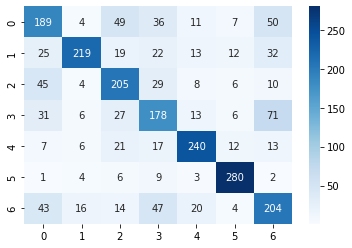

In [21]:
df = pd.DataFrame(cfm)
sns.heatmap(df,cmap="Blues",annot=True, fmt="d")